In [1]:
import sys
print(sys.prefix)

C:\Users\MAUD\anaconda3


In [2]:
import pandas as pd
import numpy as np

#sauvegarde des modèles
import joblib 

#pour slugifier une string
import re
import unicodedata

#traitement
import ast
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.utils import resample

#vectorizers and models
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.decomposition import PCA
import gc

#visualization / tracking mlflow
from sklearn.metrics import accuracy_score, classification_report, jaccard_score
import matplotlib.pyplot as plt
import mlflow
mlflow.set_tracking_uri("http://127.0.0.1:5000")
from mlflow.tracking import MlflowClient
import mlflow.sklearn
import json

#affichage des tableaux en entier
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Formatage taille cellule pour s'adapter aux graphiques
from IPython.display import display, HTML
display(HTML("<style>.output_scroll { height: auto !important; }</style>"))

df = pd.read_csv("./filtered_questions_clean.csv",sep=',', encoding='utf-8')  
df.head(5)

,Unnamed: 0,title,body,link,view_count,score,answer_count,tags,creation_date,clean_title,clean_body,word_count_title,word_count_clean_title,word_count_body,word_count_clean_body
0,0,Manifest v3 background scripts/service worker ...,<p>I'm trying to migrate my browser extension ...,https://stackoverflow.com/questions/75043889/m...,17070,48,3,"['google-chrome', 'firefox', 'cross-browser', ...",2023-01-07 21:27:38,manifest v background script service worker fi...,trying migrate browser extension expect work c...,7,7,493,263
1,1,Settings Menu missing Ubuntu 22.04,<p>So I was trying to get back the menu settin...,https://stackoverflow.com/questions/74985183/s...,42944,33,4,"['ubuntu', 'menu', 'settings', 'new-operator',...",2023-01-02 17:06:35,setting menu missing ubuntu,trying get back menu setting dissapear ubutu m...,5,4,166,150
2,2,Does &#39;use client&#39; in Next.js 13 root l...,<p>I was trying Nextjs 13 with Next-auth and A...,https://stackoverflow.com/questions/74992326/d...,32460,27,2,"['javascript', 'reactjs', 'next.js', 'server-s...",2023-01-03 10:49:12,use client next j root layout make whole route...,trying nextjs next auth apollo client wrap roo...,13,11,86,41
3,3,How can I stop Clang from overexpanding nested...,<p>Consider this code:</p>\n<pre><code>#includ...,https://stackoverflow.com/questions/74979866/h...,1385,21,3,"['c++', 'clang', 'compiler-optimization', 'tem...",2023-01-02 07:28:00,stop clang overexpanding nested loop via template,consider code include iostream typedef long xi...,11,7,124,70
4,4,Why dialog tag does not spread to the whole sc...,<p>In the middle of writing my project code I ...,https://stackoverflow.com/questions/75024007/w...,7395,20,1,"['html', 'css', 'dialog', 'height', 'width']",2023-01-05 20:28:25,dialog tag spread whole screen even though set...,middle writing project code decided change pop...,19,10,1399,2418


## Fonction pour slugifier une string

In [4]:
def slugify(value):
    # Normaliser la chaîne pour enlever les accents
    value = unicodedata.normalize('NFKD', value).encode('ascii', 'ignore').decode('ascii')
    
    # Remplacer les caractères non-alphanumériques par des tirets
    value = re.sub(r'[^a-zA-Z0-9]+', '-', value)
    
    # Enlever les tirets en début et fin de chaîne
    value = value.strip('-')
    
    # Convertir en minuscules
    return value.lower()

In [5]:
# Définir le ratio d'échantillonnage
fraction = 0.2  # Conserver 20% des données d'origine

# Échantillonnage aléatoire
df_reduit = df.sample(frac=fraction, random_state=42)  # DataFrame échantillonné

# Convertir les chaînes de caractères représentant des listes en véritables listes
df_reduit['tags'] = df_reduit['tags'].apply(ast.literal_eval)

# Convertir la colonne 'creation_date' en datetime
df_reduit['creation_date'] = pd.to_datetime(df_reduit['creation_date'])

# Trier les données par ordre chronologique
df_reduit = df_reduit.sort_values(by='creation_date')

# Filtrer les tags peu fréquents pour réduire la taille de la matrice
# Compter les occurrences des tags individuels
tag_counts = df_reduit['tags'].explode().value_counts()
common_tags = tag_counts[tag_counts >= 50].index  # Utilisez un seuil adapté

# Conserver seulement les tags les plus fréquents
df_reduit['filtered_tags'] = df_reduit['tags'].apply(lambda tags: [tag for tag in tags if tag in common_tags])

# Binariser les tags
mlb = MultiLabelBinarizer()
df_tags_reduit = mlb.fit_transform(df_reduit['filtered_tags']).astype('int8')  # Conversion en int8 pour économiser de la mémoire

# Analyse des classes et occurrences
print("Classes binarisées :", mlb.classes_)
number_of_classes = len(mlb.classes_)
print(f"Le nombre de classes uniques (tags) est : {number_of_classes}")

Classes binarisées : ['.net' '.net-core' 'algorithm' 'amazon-web-services' 'android'
 'android-studio' 'angular' 'apache-spark' 'api' 'arrays' 'asp.net'
 'asp.net-core' 'asp.net-mvc' 'async-await' 'asynchronous'
 'authentication' 'aws-lambda' 'azure' 'bash' 'beautifulsoup' 'blazor' 'c'
 'c#' 'c++' 'class' 'css' 'csv' 'dart' 'database' 'dataframe' 'date'
 'datetime' 'deep-learning' 'dictionary' 'django' 'django-models'
 'django-rest-framework' 'django-views' 'docker' 'docker-compose' 'excel'
 'express' 'filter' 'firebase' 'flask' 'flutter' 'for-loop' 'forms'
 'frontend' 'function' 'ggplot2' 'git' 'github' 'google-cloud-firestore'
 'google-cloud-platform' 'gradle' 'group-by' 'hibernate' 'html' 'http'
 'if-statement' 'image' 'ios' 'java' 'javascript' 'jestjs' 'jpa' 'jquery'
 'json' 'keras' 'kotlin' 'kubernetes' 'laravel' 'linux' 'list' 'loops'
 'machine-learning' 'macos' 'matplotlib' 'maven' 'mongodb' 'mongoose'
 'multithreading' 'mysql' 'next.js' 'node.js' 'npm' 'numpy' 'object'
 'office

In [6]:
# Compter le nombre d'occurrences de chaque classe (tag) dans le dataset
class_occurrences = df_tags_reduit.sum(axis=0)

# Associer chaque occurrence avec la classe correspondante
class_occurrences_df = pd.DataFrame({
    'Class': mlb.classes_,
    'Occurrences': class_occurrences
}).sort_values(by='Occurrences', ascending=False)

# Afficher le DataFrame contenant les occurrences de chaque classe
print(class_occurrences_df)

                      Class  Occurrences
97                   python         1867
64               javascript         1367
63                     java          775
103                 reactjs          763
22                       c#          670
58                     html          530
85                  node.js          507
4                   android          457
120              typescript          412
91                   pandas          383
25                      css          383
111             spring-boot          339
98               python-3.x          324
9                    arrays          307
23                      c++          295
29                dataframe          289
100                       r          280
45                  flutter          278
93                      php          272
113                     sql          246
34                   django          236
110                  spring          230
68                     json          224
17              

In [7]:
# Filtrer les classes ayant moins de 55 occurrences
classes_under_55 = class_occurrences_df[class_occurrences_df['Occurrences'] < 100]

# Afficher les classes et leur nombre d'occurrences
print(classes_under_55)

                      Class  Occurrences
114              sql-server           98
8                       api           97
10                  asp.net           93
15           authentication           90
18                     bash           88
82           multithreading           88
7              apache-spark           86
129            web-scraping           84
96                  pyspark           83
53   google-cloud-firestore           83
118              tensorflow           83
131               wordpress           82
128                  vuejs3           81
132                     xml           81
106                selenium           78
99                  pytorch           78
33               dictionary           77
57                hibernate           77
92              performance           72
105                    rest           72
78               matplotlib           71
124                     vba           69
121            unit-testing           69
56              

In [8]:
# Préparer les données d'entrée
X = df_reduit[['clean_title', 'clean_body', 'creation_date']]  # Ajout de creation_date pour l'évaluation temporelle

# Remplir les valeurs manquantes dans 'clean_title' et 'clean_body'
X.loc[:, 'clean_title'] = X['clean_title'].fillna("")
X.loc[:, 'clean_body'] = X['clean_body'].fillna("")

# Définir les vectorisations
count_vectorizer = CountVectorizer(stop_words='english')
tfidf_vectorizer = TfidfVectorizer(stop_words='english')

## Fonction de suréchantillonnage

In [10]:
def oversample_minority_classes(X_train_vect, y_train, threshold=100, max_target=500, random_state=42):
    """
    Suréchantillonne uniquement les classes minoritaires dans le jeu de données d'entraînement.
    """
    # Convertir la matrice sparse en DataFrame pour suréchantillonnage
    X_train_df = pd.DataFrame(X_train_vect.toarray()).astype(np.float32)  # Convert to dense array
    y_train_df = pd.DataFrame(y_train).astype(np.int8)

    # Stocker les occurrences avant suréchantillonnage
    occurrences_avant = np.sum(y_train, axis=0)

    # Initialisation pour suréchantillonnage
    X_train_oversampled = [X_train_df]
    y_train_oversampled = [y_train_df]

    # Suréchantillonner uniquement les classes minoritaires
    for i in range(y_train.shape[1]):
        class_count = np.sum(y_train[:, i])

        # Seules les classes avec des occurrences strictement inférieures au seuil sont suréchantillonnées
        if class_count < threshold:
            indices = np.where(y_train[:, i] == 1)[0]
            if len(indices) > 0:
                # Calcul du nombre d'échantillons pour atteindre max_target sans dépasser
                n_samples = min(max_target - class_count, int((threshold - class_count) * 1.5))
                
                # Suréchantillonner
                X_resampled, y_resampled = resample(
                    X_train_df.iloc[indices],
                    y_train_df.iloc[indices],
                    n_samples=n_samples,
                    random_state=random_state
                )
                
                X_train_oversampled.append(X_resampled)
                y_train_oversampled.append(y_resampled)

    # Concaténer les suréchantillons nécessaires
    X_train_oversampled = pd.concat(X_train_oversampled, ignore_index=True)
    y_train_oversampled = pd.concat(y_train_oversampled, ignore_index=True)

    return X_train_oversampled.values, y_train_oversampled.values

In [11]:
# def count_class_occurrences(y_train):
#     class_counts = y_train.sum(axis=0)  # Compte le nombre de 1 pour chaque classe
#     return class_counts

In [12]:
# def dynamic_oversample(X_train_vect, y_train, threshold=50):
#     class_counts = count_class_occurrences(y_train)
#     max_class_size = class_counts.max()
#     # Calculate dynamic n_samples based on class occurrences
#     n_samples_dict = {i: min(max_class_size, int(count * 1.5)) for i, count in enumerate(class_counts) if count < threshold}
    
#     # Oversample with dynamically adjusted n_samples
#     X_train_oversampled, y_train_oversampled = oversample_minority_classes(X_train_vect, y_train, threshold, n_samples_dict)

#     # Ajuster la taille de X_train_oversampled et y_train_oversampled
#     min_samples = min(len(X_train_oversampled), len(y_train_oversampled))
#     X_train_oversampled = X_train_oversampled[:min_samples]
#     y_train_oversampled = y_train_oversampled[:min_samples]

#     return X_train_oversampled, y_train_oversampled

## Fonction d'évaluation temporelle (Drift)

In [14]:
# Fonction d'évaluation temporelle avec suréchantillonnage
def temporal_evaluation(df, df_tags, vectorizer, model, params, time_column='creation_date', n_splits=5):
    """
    Effectue une évaluation temporelle sur le dataset avec suréchantillonnage des classes minoritaires.
    
    Parameters:
        df: Le dataframe contenant les données (X).
        df_tags: Les labels binarisés (y).
        vectorizer: Le vectoriseur à utiliser (TF-IDF ou CountVectorizer).
        model: Le modèle à entraîner.
        params: Les paramètres du modèle et de la vectorisation à enregistrer dans MLflow.
        time_column: La colonne temporelle à utiliser pour diviser les données.
        n_splits: Le nombre de périodes pour l'évaluation temporelle.
        threshold: Seuil pour la considération des classes minoritaires.
    """

    periods = pd.qcut(df[time_column], q=n_splits, labels=False)
    results = []
    
    for period in range(n_splits - 1):
        train_idx = periods <= period
        test_idx = periods == (period + 1)
        
        # Sélection des jeux de données d'entraînement et de test
        X_train, X_test = df[train_idx], df[test_idx]
        y_train, y_test = df_tags[train_idx], df_tags[test_idx]
        
        # # Limite les données d'entraînement à 10%
        # X_train_sampled = X_train.sample(frac=0.1, random_state=42)
        # y_train_sampled = y_train[X_train_sampled.index]
        
        # Remplir les valeurs manquantes dans 'clean_title' et 'clean_body'
        X_train.loc[:, 'clean_title'] = X_train['clean_title'].fillna('')
        X_train.loc[:, 'clean_body'] = X_train['clean_body'].fillna('')
        X_test.loc[:, 'clean_title'] = X_test['clean_title'].fillna('')
        X_test.loc[:, 'clean_body'] = X_test['clean_body'].fillna('')
        
        # Vectorisation
        X_train_vect = vectorizer.fit_transform(X_train['clean_title'] + " " + X_train['clean_body'])
        X_test_vect = vectorizer.transform(X_test['clean_title'] + " " + X_test['clean_body'])
        
        # Suréchantillonnage des classes minoritaires
        X_train_vect_oversampled, y_train_oversampled = oversample_minority_classes(X_train_vect, y_train)

        # Vérification visuelle de la distribution des classes avant et après suréchantillonnage
        distribution_avant = np.sum(y_train, axis=0)
        distribution_apres = np.sum(y_train_oversampled, axis=0)
        classes = np.arange(len(distribution_avant))

        # Créer un DataFrame pour visualisation plus simple
        df_distribution = pd.DataFrame({
            'Classes': classes,
            'Avant Suréchantillonnage': distribution_avant,
            'Après Suréchantillonnage': distribution_apres
        })

        # Tracer les histogrammes côte à côte
        fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharey=True)
        df_distribution.plot(kind='bar', x='Classes', y='Avant Suréchantillonnage', ax=axes[0], color='skyblue')
        df_distribution.plot(kind='bar', x='Classes', y='Après Suréchantillonnage', ax=axes[1], color='salmon')

        # Paramétrer les titres
        axes[0].set_title('Distribution des Classes Avant Suréchantillonnage')
        axes[1].set_title('Distribution des Classes Après Suréchantillonnage')

        # Ajuster labels
        for ax in axes:
            ax.set_xlabel("Classes")
            ax.set_ylabel("Fréquence")

        plt.show()
        
        # Transformation en float32 pour économiser la mémoire
        X_train_vect_oversampled = X_train_vect_oversampled.astype('float32')

        # PCA pour réduire les dimensions
        pca = PCA(n_components=100)
        X_train_vect_oversampled = pca.fit_transform(X_train_vect_oversampled)
        X_test_vect = pca.transform(X_test_vect.toarray())

        # Define a dynamic model name based on the current split and vectorizer type
        model_name = f"{params['model_type']}_{params['vectorizer']}"

        # Sauvegarder le PCA
        joblib.dump(pca, slugify(model_name) + "__temporal_split_" + str(period) + "_pca.pkl")
        
        # Entraîner et évaluer le modèle
        result = run_experiment(
            model, 
            X_train_vect_oversampled, 
            y_train_oversampled,
            X_test_vect, 
            y_test, 
            f"{model_name}__temporal_split_{period}",
            vectorizer, 
            X_test_original=X_test
        )
        
        # Collecter les résultats
        #results.append(result)

        # Logger les résultats dans MLflow
        log_experiment_to_mlflow(result, params, f"{model_name}__temporal_split_{period}", model_name=model_name)
    
    return results

## Fonction d'éxecution des modèle

In [16]:
# Fonction pour exécuter et évaluer un modèle
def run_experiment(model, X_train, y_train, X_test, y_test, method_name, vectorizer, reference_model=None, X_test_original=None):
    """
    Exécute l'entraînement et l'évaluation du modèle.
    
    Parameters:
        model: Le modèle à entraîner.
        X_train: Les features d'entraînement.
        y_train: Les labels d'entraînement.
        X_test: Les features de test.
        y_test: Les labels de test.
        method_name: Le nom de la méthode pour l'identification.
        vectorizer: Le vectoriseur utilisé pour calculer le taux de couverture des mots.
        reference_model: Un modèle de référence pour comparaison (facultatif).

    Returns:
        results: Un dictionnaire contenant l'accuracy, le rapport de classification, le Jaccard score,
                 le taux de couverture, et le modèle entraîné.
    """

    # Calculer le taux de couverture des mots en utilisant X_test_original avant PCA
    word_coverage = calculate_word_coverage(X_test_original, vectorizer) if X_test_original is not None else None

    # Convertir en dense si nécessaire
    X_train = X_train.toarray() if hasattr(X_train, 'toarray') else X_train
    y_train = y_train.toarray() if hasattr(y_train, 'toarray') else y_train
    X_test = X_test.toarray() if hasattr(X_test, 'toarray') else X_test
    y_test = y_test.toarray() if hasattr(y_test, 'toarray') else y_test

    X_train = X_train.astype('float32') # pour reduire la consommation de ressource en mémoire
        
    # Entraîner le modèle
    model.fit(X_train, y_train)

    # Sauvegarder le modèle, le vectoriseur, et le MultiLabelBinarizer
    model_name = slugify(method_name)
    joblib.dump(model, model_name + "_model.pkl")
    joblib.dump(vectorizer, model_name + "_vectorizer.pkl")
    joblib.dump(mlb, model_name + "_mlb.pkl")
    
    # Prédire les probabilités sur l'ensemble de test
    y_pred_proba = model.predict_proba(X_test)
    
    # Initialiser une matrice vide pour les prédictions
    y_pred = np.zeros_like(y_pred_proba, dtype=int)
    
    # Appliquer le seuil de 0.5 et assigner les prédictions
    threshold = 0.5
    for i, proba in enumerate(y_pred_proba):
        indices_above_threshold = np.where(proba >= threshold)[0]
        if len(indices_above_threshold) > 0:
            y_pred[i, indices_above_threshold] = 1
        else:
            top_5_indices = np.argsort(proba)[-5:]
            y_pred[i, top_5_indices] = 1
    
    # Calculer les métriques
    accuracy = accuracy_score(y_test, y_pred)
    jaccard = jaccard_score(y_test, y_pred, average='samples', zero_division=0)
    report = classification_report(y_test, y_pred, target_names=mlb.classes_, zero_division=0, output_dict=True)
    global_metrics = {
        "micro avg" : report["micro avg"],
        "macro avg": report["macro avg"],
        "weighted avg": report["weighted avg"],
        "samples avg": report["samples avg"],
    }
    global_metrics_text = json.dumps(global_metrics, indent=4)
    
    # Retourner les résultats sous forme de dictionnaire
    results = {
        "accuracy": accuracy,
        "jaccard": jaccard,
        "word_coverage": word_coverage,
        "report": global_metrics_text,
        "model": model
    }
    
    print(f"{method_name} Classification Report:")
    print(global_metrics_text)
    print(f"Jaccard Score: {jaccard:.2f}")
    print(f"Word Coverage: {word_coverage:.2f}" if word_coverage is not None else "Word Coverage not calculated")
    
    return results

## Fonction du calcule du taux de couverture

In [18]:
# Fonction pour calculer le taux de couverture des mots
def calculate_word_coverage(X_test, vectorizer):
    """
    Calcule le taux de couverture des mots dans le jeu de test par rapport au vocabulaire du vectorizer.
    
    Parameters:
        X_test: Jeu de test (DataFrame avec des colonnes 'clean_title' et 'clean_body')
        vectorizer: Vectoriseur déjà entraîné sur le jeu d'entraînement
    
    Returns:
        coverage_rate: Le pourcentage de mots du jeu de test couverts par le vocabulaire du vectorizer
    """

    # Vérification et conversion de X_test en DataFrame si nécessaire
    if isinstance(X_test, np.ndarray):
        X_test = pd.DataFrame(X_test, columns=vectorizer.get_feature_names_out())
        
    # Remplir les valeurs manquantes avec des chaînes vides
    X_test.loc[:, :] = X_test.loc[:, :].fillna("")
    
    # Nombre total de mots uniques dans le vocabulaire (déjà appris lors du fit sur X_train)
    total_vocab = len(vectorizer.get_feature_names_out())
    
    # Transformer les questions de test pour obtenir les mots utilisés dans X_test
    X_test_transformed = vectorizer.transform(X_test['clean_title'] + " " + X_test['clean_body'])
    
    # Compter le nombre de mots uniques utilisés dans le jeu de test
    word_usage = (X_test_transformed > 0).sum(axis=0)
    covered_words = (word_usage > 0).sum()
    
    # Calculer le taux de couverture par rapport au vocabulaire total
    coverage_rate = covered_words / total_vocab
    return coverage_rate

## Fonction de récupération des logs sur MLFlow

In [20]:
# Fonction pour loguer les résultats dans MLflow
def log_experiment_to_mlflow(results, params, method_name, threshold=0.5, model_name="My_Model"):
    """
    Enregistre les résultats de l'expérimentation dans MLflow et enregistre le modèle dans le Model Registry.
    
    Parameters:
        results: Un dictionnaire contenant l'accuracy, le rapport de classification, et le modèle entraîné.
        params: Les paramètres du modèle et de la vectorisation à enregistrer dans MLflow.
        method_name: Le nom de la méthode pour l'identification.
        threshold: Le seuil utilisé pour déterminer les classes avec predict_proba.
        model_name: Le nom sous lequel le modèle sera enregistré dans le Model Registry.
    """
    with mlflow.start_run(run_name=method_name) as run:
        # Loguer les paramètres
        mlflow.log_params(params)
        
        # Loguer les métriques
        mlflow.log_metric("accuracy", results["accuracy"])
        mlflow.log_metric("jaccard_score", results["jaccard"])
        mlflow.log_metric("word_coverage", results["word_coverage"])
        
        # Loguer le seuil utilisé pour les prédictions avec predict_proba
        mlflow.log_param("threshold", threshold)
        
        # Loguer la logique d'application du seuil et de sélection des 5 meilleures probabilités
        mlflow.log_param("prediction_logic", "Threshold at 0.5, top 5 if none above threshold")
        
        # Loguer le rapport de classification comme un fichier texte
        mlflow.log_text(results["report"], f"classification_report_{method_name}.txt")
        
        # Loguer le modèle comme un artefact MLflow
        mlflow.sklearn.log_model(results["model"], f"{method_name}_model")

        # Enregistrement du modèle dans le registre de modèles
        model_uri = f"runs:/{run.info.run_id}/{method_name}_model"
        try:
            registered_model = mlflow.register_model(model_uri, model_name)
            print(f"Le modèle '{method_name}' a été enregistré dans le Model Registry avec le nom '{model_name}'.")
        
        except Exception as e:
            print(f"Erreur lors de l'enregistrement dans le Model Registry: {e}")

In [21]:
# Définir les modèles
logistic_regression_model = OneVsRestClassifier(LogisticRegression(max_iter=1000, random_state=42, class_weight='balanced'))
#Tester d'autres hyperparamètres :
    # C : Ce paramètre contrôle la régularisation inverse. Vous pourriez essayer différentes valeurs de C pour voir comment le modèle réagit (par exemple, 0.1, 1, 10).
    # solver : Le solver 'lbfgs' est utilisé par défaut pour les problèmes multiclasses, mais si vous avez des données denses, d'autres solveurs comme 'saga' peuvent être plus efficaces.
    #Utiliser GridSearchCV pour trouver les meilleures valeur d'hyperparamètre

sgd_classifier_model = OneVsRestClassifier(SGDClassifier(max_iter=1000, random_state=42, class_weight='balanced', loss='log_loss'))
#Tester d'autres hyperparamètres :
    # C : Ce paramètre contrôle la régularisation inverse. Vous pourriez essayer différentes valeurs de C pour voir comment le modèle réagit (par exemple, 0.1, 1, 10).
    # solver : Le solver 'lbfgs' est utilisé par défaut pour les problèmes multiclasses, mais si vous avez des données denses, d'autres solveurs comme 'saga' peuvent être plus efficaces.
    #Utiliser GridSearchCV pour trouver les meilleures valeur d'hyperparamètre

# Définir les paramètres et exécuter les expériences
# CountVectorizer + Logistic Regression
params_count_lr = {
    "model_type": "Logistic Regression (OneVsRest)",
    "vectorizer": "CountVectorizer"
}

# TF-IDF + Logistic Regression
params_tfidf_lr = {
    "model_type": "Logistic Regression (OneVsRest)",
    "vectorizer": "TfidfVectorizer"
}

# CountVectorizer + SGDClassifier
params_count_sgd = {
    "model_type": "SGDClassifier (OneVsRest)",
    "vectorizer": "CountVectorizer"
}

# TF-IDF + SGDClassifier
params_tfidf_sgd = {
    "model_type": "SGDClassifier (OneVsRest)",
    "vectorizer": "TfidfVectorizer"
}


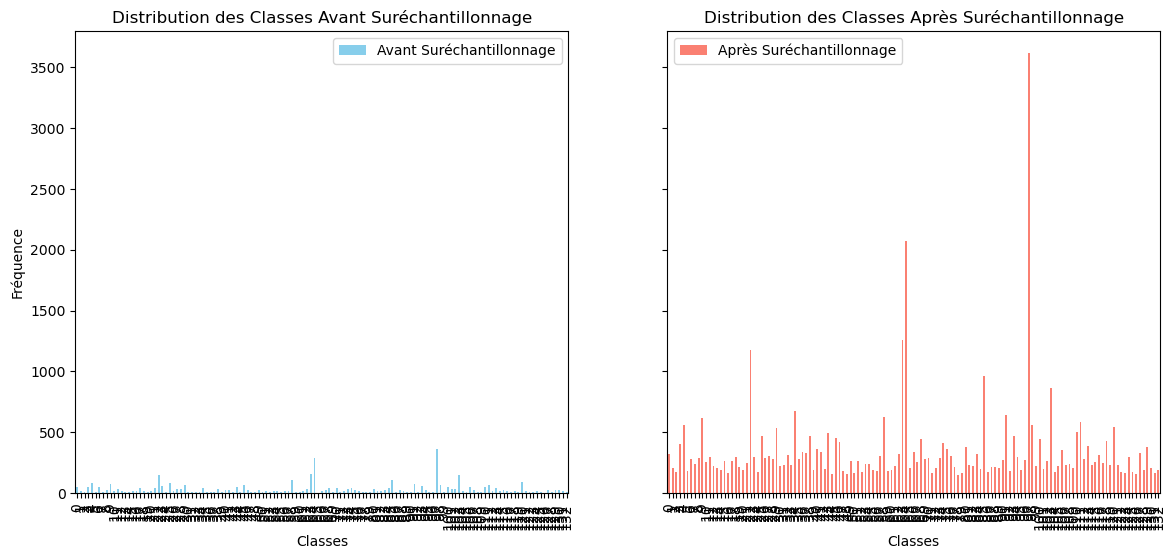

Logistic Regression (OneVsRest)_TfidfVectorizer__temporal_split_0 Classification Report:
{
    "micro avg": {
        "precision": 0.26226893121891715,
        "recall": 0.6359499431171786,
        "f1-score": 0.3713792187084773,
        "support": 4395.0
    },
    "macro avg": {
        "precision": 0.2924560743437954,
        "recall": 0.5370721512000421,
        "f1-score": 0.33609006304692135,
        "support": 4395.0
    },
    "weighted avg": {
        "precision": 0.35004794376035564,
        "recall": 0.6359499431171786,
        "f1-score": 0.42632635042216477,
        "support": 4395.0
    },
    "samples avg": {
        "precision": 0.2955491354319914,
        "recall": 0.582425,
        "f1-score": 0.3527026513991684,
        "support": 4395.0
    }
}
Jaccard Score: 0.25
Word Coverage: 0.36


Successfully registered model 'Logistic Regression (OneVsRest)_TfidfVectorizer'.
2024/11/08 21:06:01 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Logistic Regression (OneVsRest)_TfidfVectorizer, version 1
Created version '1' of model 'Logistic Regression (OneVsRest)_TfidfVectorizer'.


Le modèle 'Logistic Regression (OneVsRest)_TfidfVectorizer__temporal_split_0' a été enregistré dans le Model Registry avec le nom 'Logistic Regression (OneVsRest)_TfidfVectorizer'.


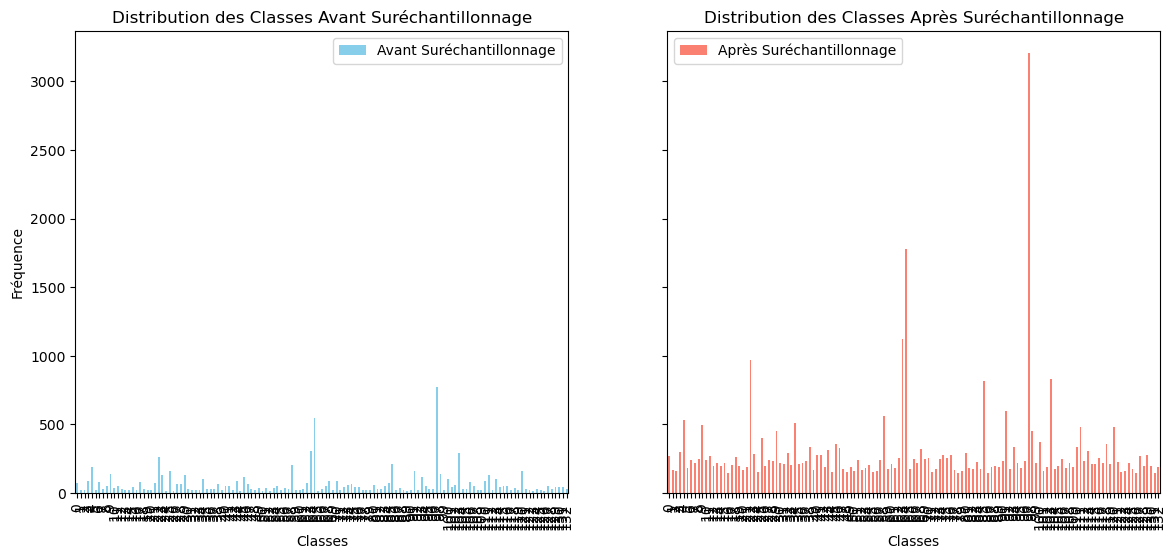

Logistic Regression (OneVsRest)_TfidfVectorizer__temporal_split_1 Classification Report:
{
    "micro avg": {
        "precision": 0.22343208654458036,
        "recall": 0.7292868682206324,
        "f1-score": 0.34206538211734144,
        "support": 4333.0
    },
    "macro avg": {
        "precision": 0.22627127463868,
        "recall": 0.6770063263488939,
        "f1-score": 0.31848792212017357,
        "support": 4333.0
    },
    "weighted avg": {
        "precision": 0.3259676000461885,
        "recall": 0.7292868682206324,
        "f1-score": 0.4285798175165431,
        "support": 4333.0
    },
    "samples avg": {
        "precision": 0.24591360667840928,
        "recall": 0.6701083333333333,
        "f1-score": 0.3307308910972829,
        "support": 4333.0
    }
}
Jaccard Score: 0.22
Word Coverage: 0.28


C:\Users\MAUD\anaconda3\Lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
C:\Users\MAUD\anaconda3\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
Registered model 'Logistic Regression (OneVsRest)_TfidfVectorizer' already exists. Creating a new version of this model...
2024/11/08 21:06:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Logistic Regression (OneVsRest)_TfidfVectorizer, version 2
Creat

Le modèle 'Logistic Regression (OneVsRest)_TfidfVectorizer__temporal_split_1' a été enregistré dans le Model Registry avec le nom 'Logistic Regression (OneVsRest)_TfidfVectorizer'.


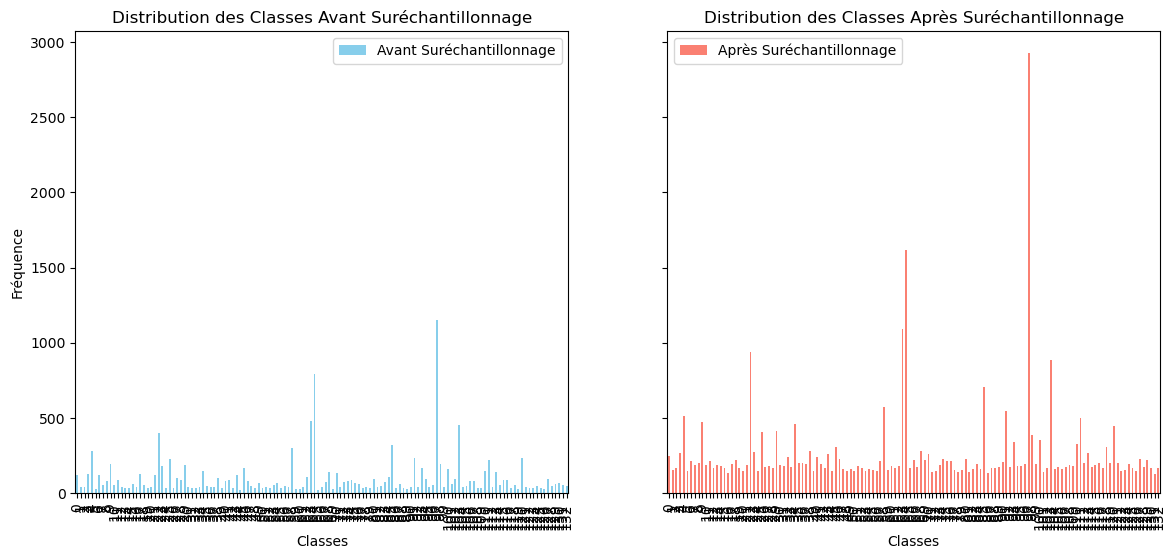

Logistic Regression (OneVsRest)_TfidfVectorizer__temporal_split_2 Classification Report:
{
    "micro avg": {
        "precision": 0.20556547435818506,
        "recall": 0.7801401869158878,
        "f1-score": 0.32539102470399067,
        "support": 4280.0
    },
    "macro avg": {
        "precision": 0.20026015127690713,
        "recall": 0.7513950772279825,
        "f1-score": 0.29978626109271217,
        "support": 4280.0
    },
    "weighted avg": {
        "precision": 0.3089443441886545,
        "recall": 0.7801401869158878,
        "f1-score": 0.4188026469084227,
        "support": 4280.0
    },
    "samples avg": {
        "precision": 0.23027014041796703,
        "recall": 0.7146166666666666,
        "f1-score": 0.3222860104721,
        "support": 4280.0
    }
}
Jaccard Score: 0.21
Word Coverage: 0.23


C:\Users\MAUD\anaconda3\Lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
C:\Users\MAUD\anaconda3\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
Registered model 'Logistic Regression (OneVsRest)_TfidfVectorizer' already exists. Creating a new version of this model...
2024/11/08 21:07:14 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Logistic Regression (OneVsRest)_TfidfVectorizer, version 3
Creat

Le modèle 'Logistic Regression (OneVsRest)_TfidfVectorizer__temporal_split_2' a été enregistré dans le Model Registry avec le nom 'Logistic Regression (OneVsRest)_TfidfVectorizer'.


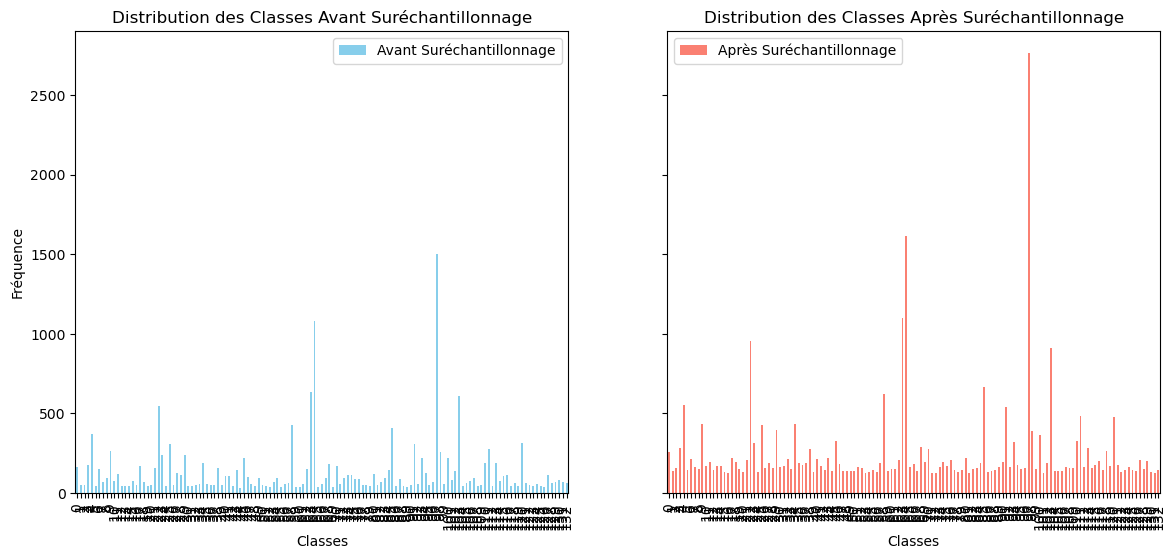

Logistic Regression (OneVsRest)_TfidfVectorizer__temporal_split_3 Classification Report:
{
    "micro avg": {
        "precision": 0.18224896177190927,
        "recall": 0.8057909604519774,
        "f1-score": 0.29726443768996963,
        "support": 4248.0
    },
    "macro avg": {
        "precision": 0.17687239195035334,
        "recall": 0.7681845723594789,
        "f1-score": 0.2730558743030944,
        "support": 4248.0
    },
    "weighted avg": {
        "precision": 0.28890531482886006,
        "recall": 0.8057909604519774,
        "f1-score": 0.3997043648769607,
        "support": 4248.0
    },
    "samples avg": {
        "precision": 0.20392483587014681,
        "recall": 0.7435166666666666,
        "f1-score": 0.2979520722625515,
        "support": 4248.0
    }
}
Jaccard Score: 0.19
Word Coverage: 0.20


C:\Users\MAUD\anaconda3\Lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
C:\Users\MAUD\anaconda3\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
Registered model 'Logistic Regression (OneVsRest)_TfidfVectorizer' already exists. Creating a new version of this model...
2024/11/08 21:08:02 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Logistic Regression (OneVsRest)_TfidfVectorizer, version 4
Creat

Le modèle 'Logistic Regression (OneVsRest)_TfidfVectorizer__temporal_split_3' a été enregistré dans le Model Registry avec le nom 'Logistic Regression (OneVsRest)_TfidfVectorizer'.


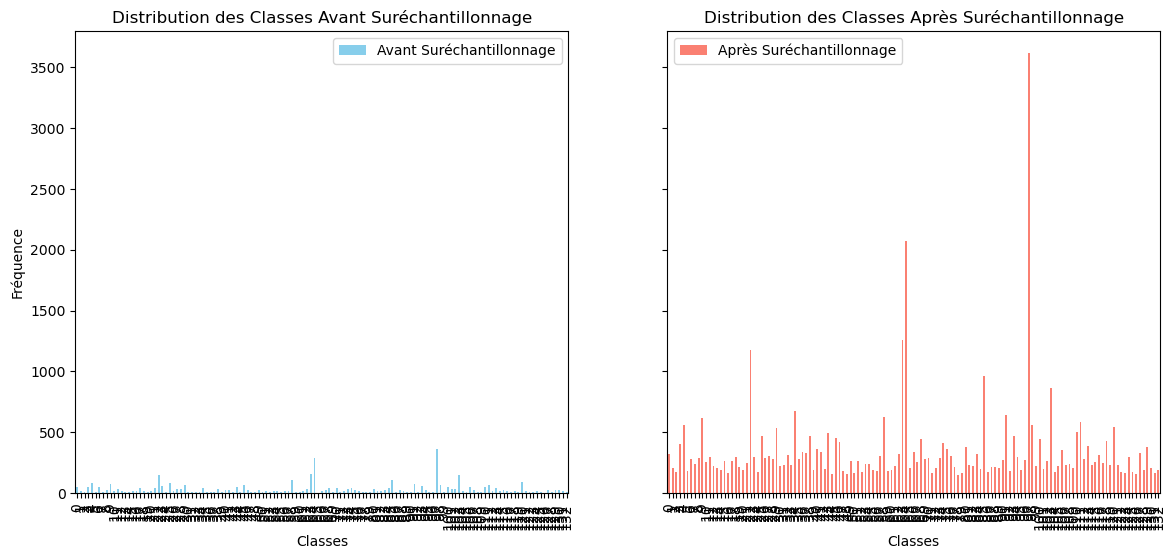

Logistic Regression (OneVsRest)_CountVectorizer__temporal_split_0 Classification Report:
{
    "micro avg": {
        "precision": 0.19696702521601128,
        "recall": 0.5083048919226394,
        "f1-score": 0.28391688377708585,
        "support": 4395.0
    },
    "macro avg": {
        "precision": 0.170970289843738,
        "recall": 0.356508140677312,
        "f1-score": 0.21659276789263596,
        "support": 4395.0
    },
    "weighted avg": {
        "precision": 0.24471394687928696,
        "recall": 0.5083048919226394,
        "f1-score": 0.3169007068867772,
        "support": 4395.0
    },
    "samples avg": {
        "precision": 0.27039925634409934,
        "recall": 0.47923333333333334,
        "f1-score": 0.30038134027402336,
        "support": 4395.0
    }
}
Jaccard Score: 0.21
Word Coverage: 0.36


C:\Users\MAUD\anaconda3\Lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
C:\Users\MAUD\anaconda3\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
Successfully registered model 'Logistic Regression (OneVsRest)_CountVectorizer'.
2024/11/08 21:09:04 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Logistic Regression (OneVsRest)_CountVectorizer, version 1
Created version '1' of model 'Logistic Regressi

Le modèle 'Logistic Regression (OneVsRest)_CountVectorizer__temporal_split_0' a été enregistré dans le Model Registry avec le nom 'Logistic Regression (OneVsRest)_CountVectorizer'.


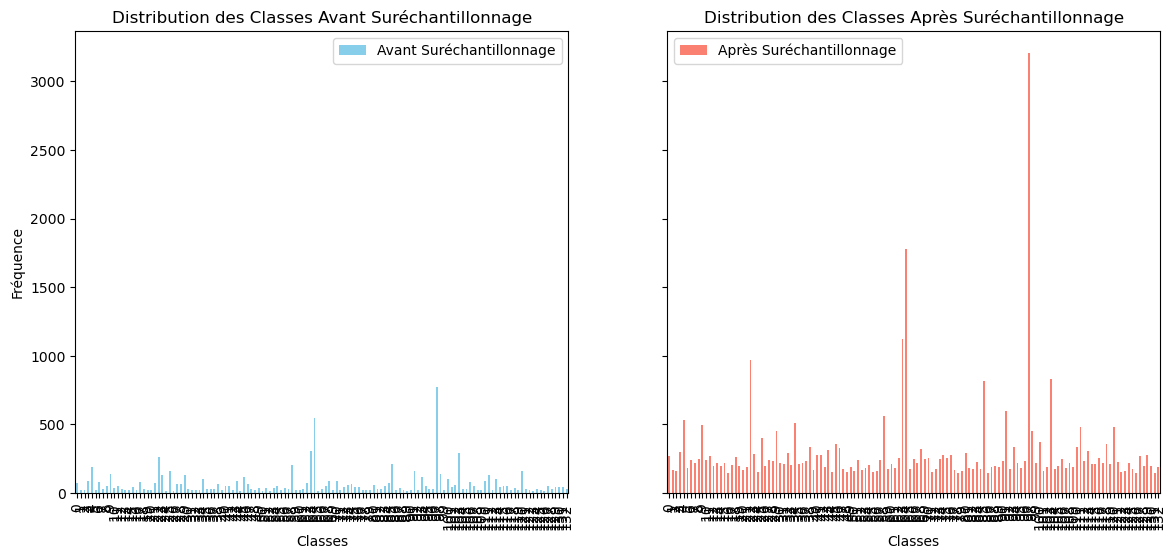

Logistic Regression (OneVsRest)_CountVectorizer__temporal_split_1 Classification Report:
{
    "micro avg": {
        "precision": 0.16417624521072796,
        "recall": 0.5933533348719132,
        "f1-score": 0.257190016505777,
        "support": 4333.0
    },
    "macro avg": {
        "precision": 0.14880288223529625,
        "recall": 0.45417489348259676,
        "f1-score": 0.21070715708095883,
        "support": 4333.0
    },
    "weighted avg": {
        "precision": 0.2351452518614681,
        "recall": 0.5933533348719132,
        "f1-score": 0.3217850373577055,
        "support": 4333.0
    },
    "samples avg": {
        "precision": 0.23180299005526003,
        "recall": 0.5556333333333334,
        "f1-score": 0.28709784481518974,
        "support": 4333.0
    }
}
Jaccard Score: 0.19
Word Coverage: 0.28


C:\Users\MAUD\anaconda3\Lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
C:\Users\MAUD\anaconda3\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
Registered model 'Logistic Regression (OneVsRest)_CountVectorizer' already exists. Creating a new version of this model...
2024/11/08 21:10:12 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Logistic Regression (OneVsRest)_CountVectorizer, version 2
Creat

Le modèle 'Logistic Regression (OneVsRest)_CountVectorizer__temporal_split_1' a été enregistré dans le Model Registry avec le nom 'Logistic Regression (OneVsRest)_CountVectorizer'.


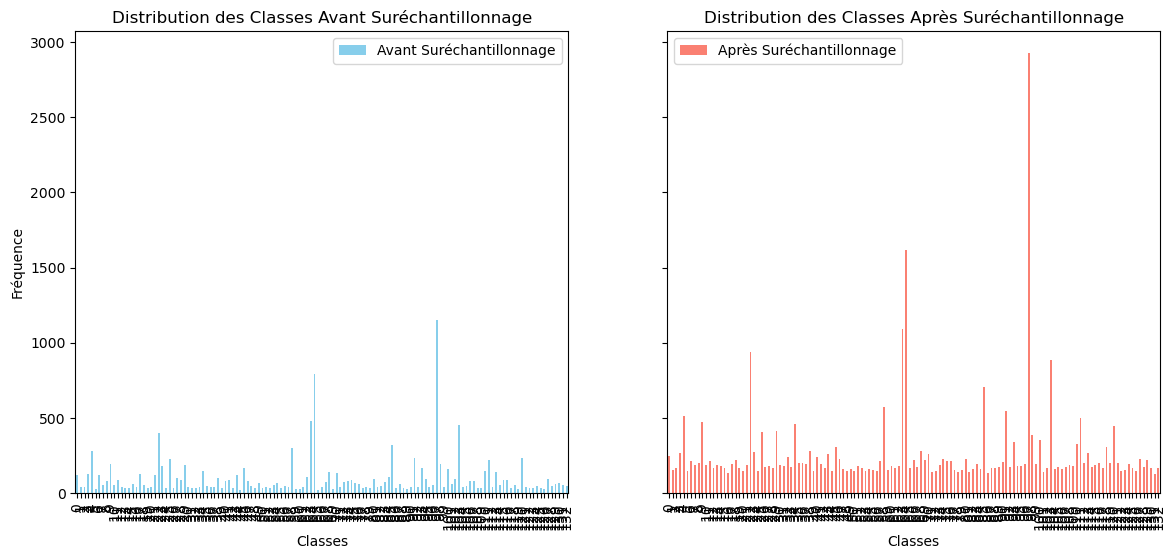

Logistic Regression (OneVsRest)_CountVectorizer__temporal_split_2 Classification Report:
{
    "micro avg": {
        "precision": 0.13936726006191952,
        "recall": 0.6731308411214953,
        "f1-score": 0.23092337287592177,
        "support": 4280.0
    },
    "macro avg": {
        "precision": 0.13025289167219958,
        "recall": 0.5606629499699872,
        "f1-score": 0.1997542239676701,
        "support": 4280.0
    },
    "weighted avg": {
        "precision": 0.22422372354246292,
        "recall": 0.6731308411214953,
        "f1-score": 0.3172171552129634,
        "support": 4280.0
    },
    "samples avg": {
        "precision": 0.2025565901666603,
        "recall": 0.6298583333333333,
        "f1-score": 0.27084671670373794,
        "support": 4280.0
    }
}
Jaccard Score: 0.18
Word Coverage: 0.23


C:\Users\MAUD\anaconda3\Lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
C:\Users\MAUD\anaconda3\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
Registered model 'Logistic Regression (OneVsRest)_CountVectorizer' already exists. Creating a new version of this model...
2024/11/08 21:11:24 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Logistic Regression (OneVsRest)_CountVectorizer, version 3
Creat

Le modèle 'Logistic Regression (OneVsRest)_CountVectorizer__temporal_split_2' a été enregistré dans le Model Registry avec le nom 'Logistic Regression (OneVsRest)_CountVectorizer'.


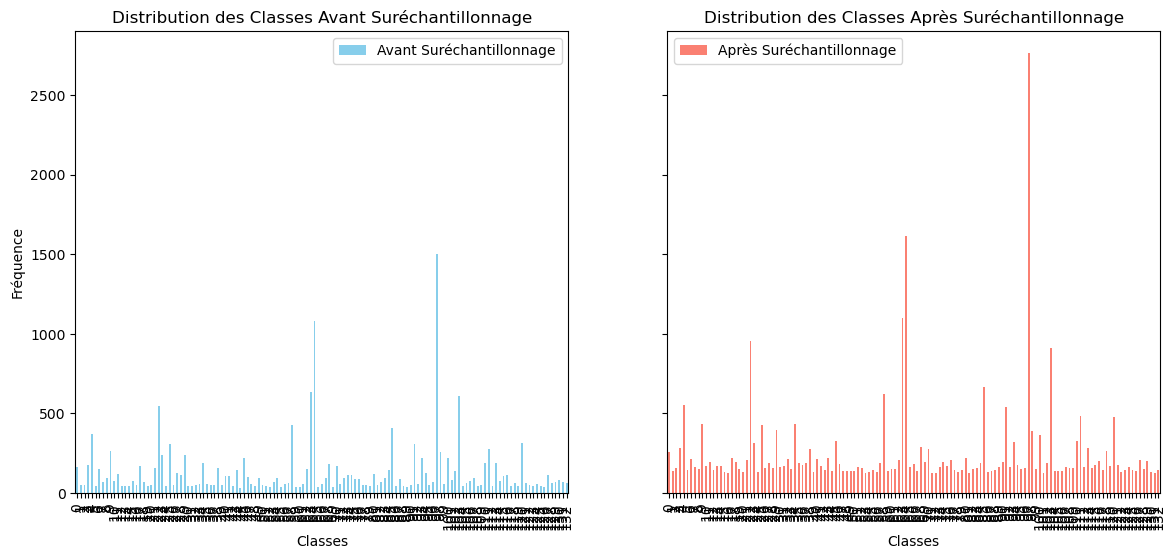

Logistic Regression (OneVsRest)_CountVectorizer__temporal_split_3 Classification Report:
{
    "micro avg": {
        "precision": 0.12452499269219526,
        "recall": 0.7019774011299436,
        "f1-score": 0.21152686646568541,
        "support": 4248.0
    },
    "macro avg": {
        "precision": 0.11536282298026204,
        "recall": 0.6026066913766929,
        "f1-score": 0.18340494436616292,
        "support": 4248.0
    },
    "weighted avg": {
        "precision": 0.21722893783469782,
        "recall": 0.7019774011299436,
        "f1-score": 0.3089162821153265,
        "support": 4248.0
    },
    "samples avg": {
        "precision": 0.17266613661198704,
        "recall": 0.6525,
        "f1-score": 0.2449978251389047,
        "support": 4248.0
    }
}
Jaccard Score: 0.16
Word Coverage: 0.20


C:\Users\MAUD\anaconda3\Lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
C:\Users\MAUD\anaconda3\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
Registered model 'Logistic Regression (OneVsRest)_CountVectorizer' already exists. Creating a new version of this model...
2024/11/08 21:12:45 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: Logistic Regression (OneVsRest)_CountVectorizer, version 4
Creat

Le modèle 'Logistic Regression (OneVsRest)_CountVectorizer__temporal_split_3' a été enregistré dans le Model Registry avec le nom 'Logistic Regression (OneVsRest)_CountVectorizer'.


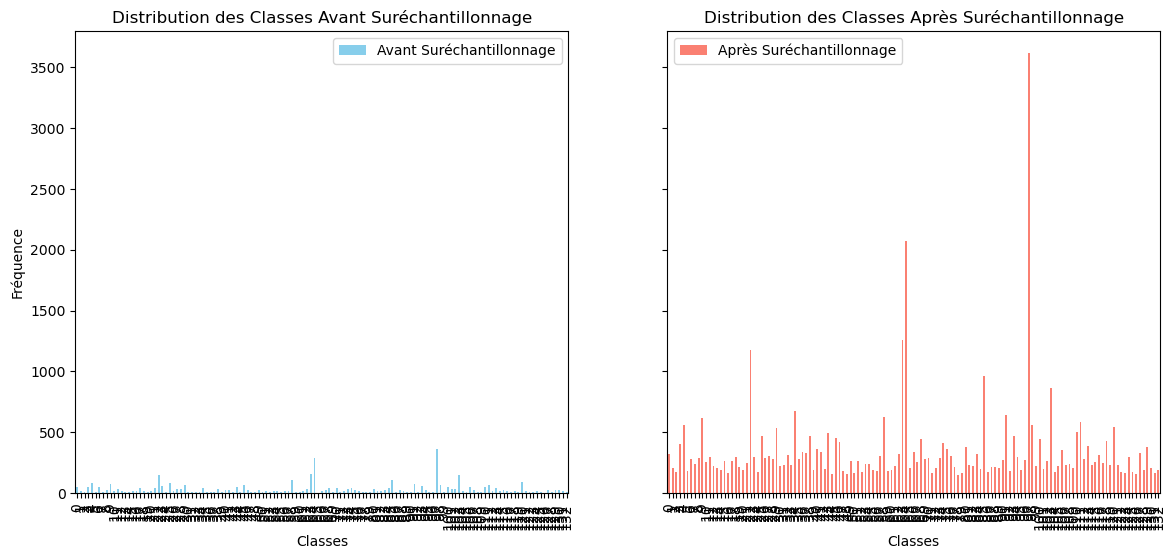

SGDClassifier (OneVsRest)_TfidfVectorizer__temporal_split_0 Classification Report:
{
    "micro avg": {
        "precision": 0.2477648933345136,
        "recall": 0.6368600682593857,
        "f1-score": 0.35674228906449146,
        "support": 4395.0
    },
    "macro avg": {
        "precision": 0.2858481662704172,
        "recall": 0.5459985062721153,
        "f1-score": 0.3311185481387255,
        "support": 4395.0
    },
    "weighted avg": {
        "precision": 0.3484721726394812,
        "recall": 0.6368600682593857,
        "f1-score": 0.4213315244097316,
        "support": 4395.0
    },
    "samples avg": {
        "precision": 0.2731464551637733,
        "recall": 0.5840250000000001,
        "f1-score": 0.33690298513238004,
        "support": 4395.0
    }
}
Jaccard Score: 0.23
Word Coverage: 0.36


C:\Users\MAUD\anaconda3\Lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
C:\Users\MAUD\anaconda3\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
Successfully registered model 'SGDClassifier (OneVsRest)_TfidfVectorizer'.
2024/11/08 21:13:15 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: SGDClassifier (OneVsRest)_TfidfVectorizer, version 1
Created version '1' of model 'SGDClassifier (OneVsRest)_Tfi

Le modèle 'SGDClassifier (OneVsRest)_TfidfVectorizer__temporal_split_0' a été enregistré dans le Model Registry avec le nom 'SGDClassifier (OneVsRest)_TfidfVectorizer'.


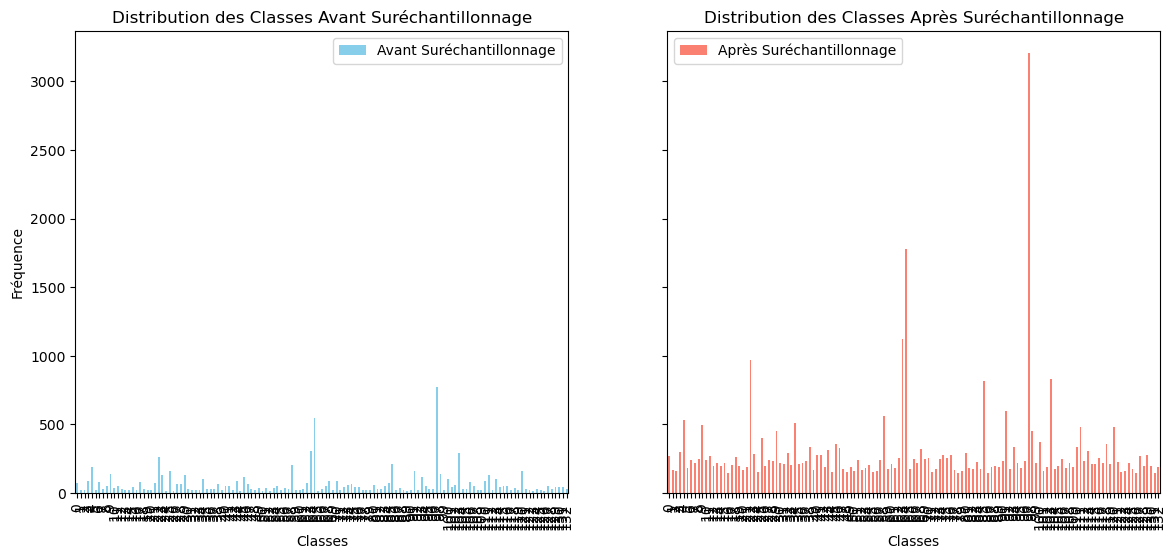

SGDClassifier (OneVsRest)_TfidfVectorizer__temporal_split_1 Classification Report:
{
    "micro avg": {
        "precision": 0.22278262122631312,
        "recall": 0.713593353334872,
        "f1-score": 0.3395563364814408,
        "support": 4333.0
    },
    "macro avg": {
        "precision": 0.2271521040795695,
        "recall": 0.6600344482383093,
        "f1-score": 0.31593869020193543,
        "support": 4333.0
    },
    "weighted avg": {
        "precision": 0.3291001365715837,
        "recall": 0.713593353334872,
        "f1-score": 0.4272633991798724,
        "support": 4333.0
    },
    "samples avg": {
        "precision": 0.24211709445525237,
        "recall": 0.6537833333333333,
        "f1-score": 0.32523796016923356,
        "support": 4333.0
    }
}
Jaccard Score: 0.22
Word Coverage: 0.28


C:\Users\MAUD\anaconda3\Lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
C:\Users\MAUD\anaconda3\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
Registered model 'SGDClassifier (OneVsRest)_TfidfVectorizer' already exists. Creating a new version of this model...
2024/11/08 21:13:51 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: SGDClassifier (OneVsRest)_TfidfVectorizer, version 2
Created version '

Le modèle 'SGDClassifier (OneVsRest)_TfidfVectorizer__temporal_split_1' a été enregistré dans le Model Registry avec le nom 'SGDClassifier (OneVsRest)_TfidfVectorizer'.


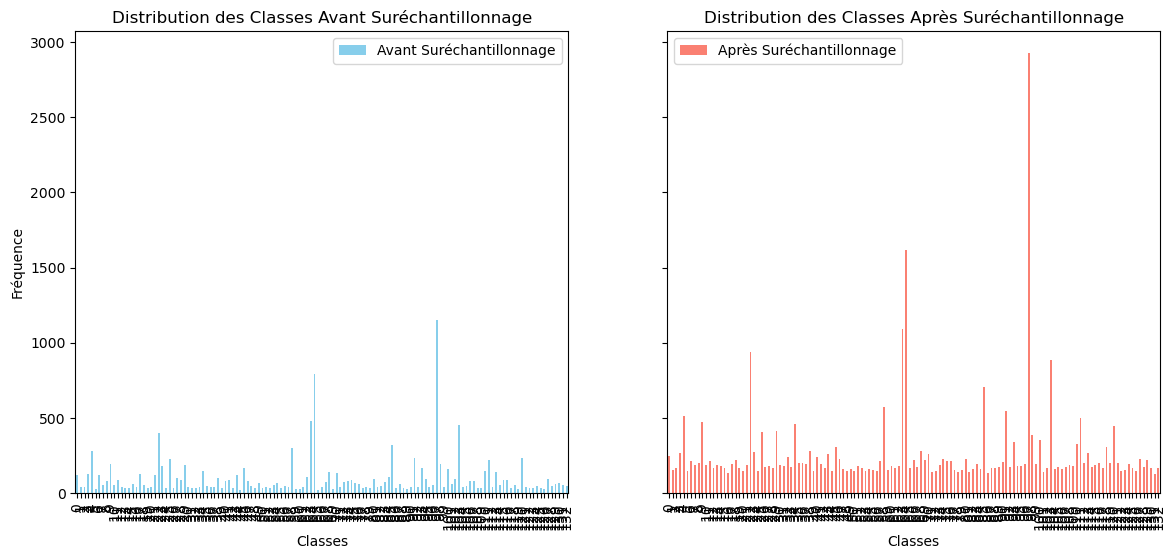

SGDClassifier (OneVsRest)_TfidfVectorizer__temporal_split_2 Classification Report:
{
    "micro avg": {
        "precision": 0.20425531914893616,
        "recall": 0.7738317757009345,
        "f1-score": 0.3232007806782142,
        "support": 4280.0
    },
    "macro avg": {
        "precision": 0.20997004429313093,
        "recall": 0.740744784180818,
        "f1-score": 0.3052171009005953,
        "support": 4280.0
    },
    "weighted avg": {
        "precision": 0.3177273885067396,
        "recall": 0.7738317757009345,
        "f1-score": 0.42380768879317865,
        "support": 4280.0
    },
    "samples avg": {
        "precision": 0.2280906271317262,
        "recall": 0.7074749999999999,
        "f1-score": 0.3183293556191975,
        "support": 4280.0
    }
}
Jaccard Score: 0.21
Word Coverage: 0.23


C:\Users\MAUD\anaconda3\Lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
C:\Users\MAUD\anaconda3\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
Registered model 'SGDClassifier (OneVsRest)_TfidfVectorizer' already exists. Creating a new version of this model...
2024/11/08 21:14:35 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: SGDClassifier (OneVsRest)_TfidfVectorizer, version 3
Created version '

Le modèle 'SGDClassifier (OneVsRest)_TfidfVectorizer__temporal_split_2' a été enregistré dans le Model Registry avec le nom 'SGDClassifier (OneVsRest)_TfidfVectorizer'.


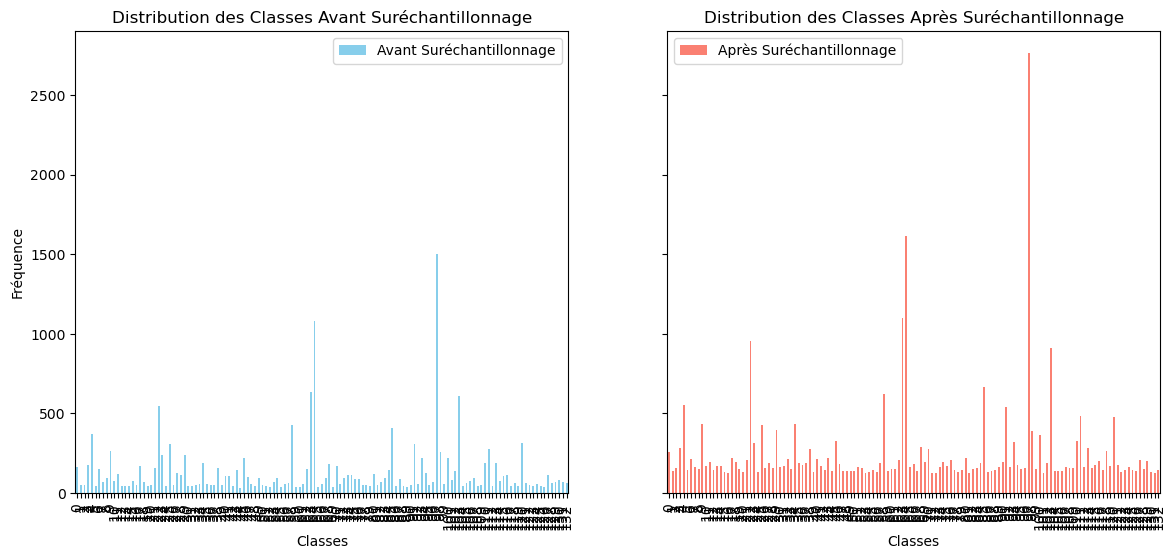

SGDClassifier (OneVsRest)_TfidfVectorizer__temporal_split_3 Classification Report:
{
    "micro avg": {
        "precision": 0.17498294768875597,
        "recall": 0.785075329566855,
        "f1-score": 0.28618011756124767,
        "support": 4248.0
    },
    "macro avg": {
        "precision": 0.18309111558398625,
        "recall": 0.7589998884718705,
        "f1-score": 0.2761775034403388,
        "support": 4248.0
    },
    "weighted avg": {
        "precision": 0.29769282420281085,
        "recall": 0.785075329566855,
        "f1-score": 0.40310385599459814,
        "support": 4248.0
    },
    "samples avg": {
        "precision": 0.19061478717687913,
        "recall": 0.7224333333333334,
        "f1-score": 0.2815690204170428,
        "support": 4248.0
    }
}
Jaccard Score: 0.18
Word Coverage: 0.20


C:\Users\MAUD\anaconda3\Lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
C:\Users\MAUD\anaconda3\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
Registered model 'SGDClassifier (OneVsRest)_TfidfVectorizer' already exists. Creating a new version of this model...
2024/11/08 21:15:29 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: SGDClassifier (OneVsRest)_TfidfVectorizer, version 4
Created version '

Le modèle 'SGDClassifier (OneVsRest)_TfidfVectorizer__temporal_split_3' a été enregistré dans le Model Registry avec le nom 'SGDClassifier (OneVsRest)_TfidfVectorizer'.


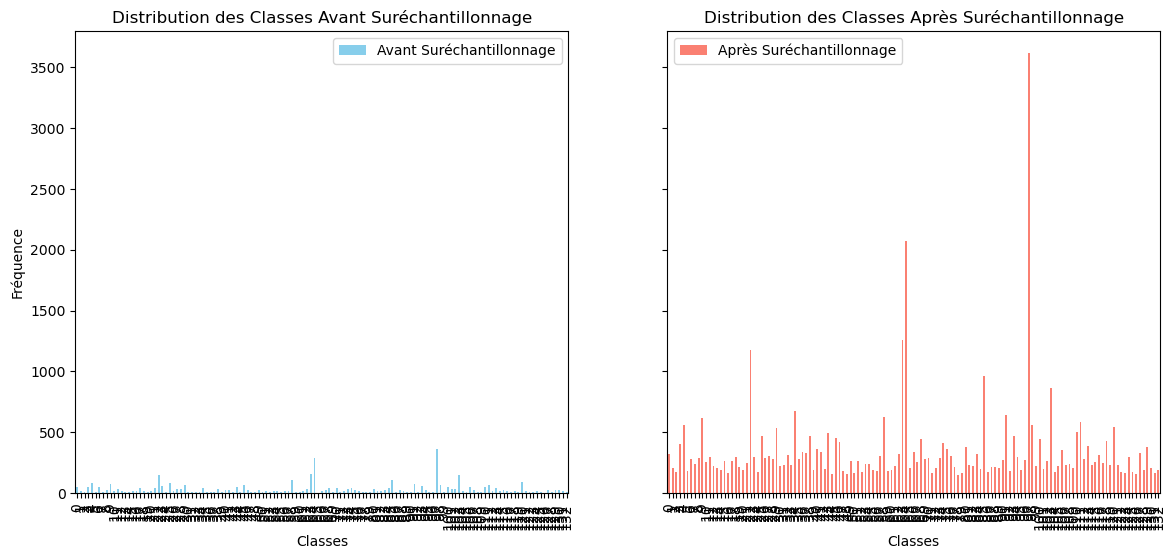

SGDClassifier (OneVsRest)_CountVectorizer__temporal_split_0 Classification Report:
{
    "micro avg": {
        "precision": 0.19300027703389047,
        "recall": 0.47554038680318544,
        "f1-score": 0.2745664739884393,
        "support": 4395.0
    },
    "macro avg": {
        "precision": 0.1842204577926571,
        "recall": 0.3208678693369463,
        "f1-score": 0.20821058032036038,
        "support": 4395.0
    },
    "weighted avg": {
        "precision": 0.2376483729927807,
        "recall": 0.47554038680318544,
        "f1-score": 0.29861274022330286,
        "support": 4395.0
    },
    "samples avg": {
        "precision": 0.280029305792888,
        "recall": 0.4508083333333333,
        "f1-score": 0.29530182733653554,
        "support": 4395.0
    }
}
Jaccard Score: 0.21
Word Coverage: 0.36


C:\Users\MAUD\anaconda3\Lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
C:\Users\MAUD\anaconda3\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
Successfully registered model 'SGDClassifier (OneVsRest)_CountVectorizer'.
2024/11/08 21:16:07 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: SGDClassifier (OneVsRest)_CountVectorizer, version 1
Created version '1' of model 'SGDClassifier (OneVsRest)_Cou

Le modèle 'SGDClassifier (OneVsRest)_CountVectorizer__temporal_split_0' a été enregistré dans le Model Registry avec le nom 'SGDClassifier (OneVsRest)_CountVectorizer'.


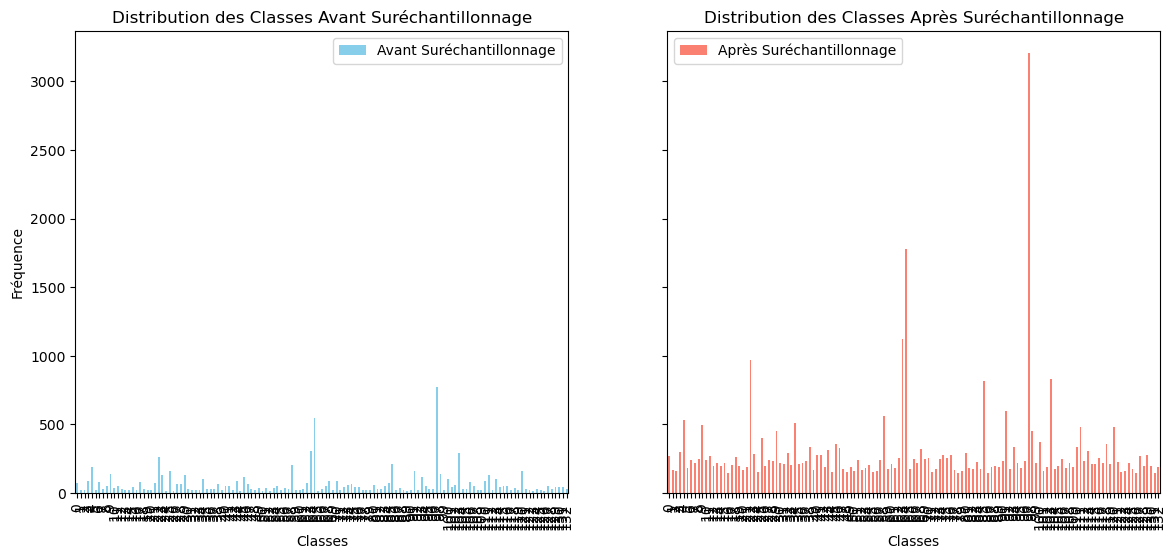

SGDClassifier (OneVsRest)_CountVectorizer__temporal_split_1 Classification Report:
{
    "micro avg": {
        "precision": 0.15495495495495495,
        "recall": 0.5755827371336256,
        "f1-score": 0.24417466222831408,
        "support": 4333.0
    },
    "macro avg": {
        "precision": 0.14893297766702307,
        "recall": 0.45114537016729456,
        "f1-score": 0.20843548455631047,
        "support": 4333.0
    },
    "weighted avg": {
        "precision": 0.22085839391514628,
        "recall": 0.5755827371336256,
        "f1-score": 0.3050437743075803,
        "support": 4333.0
    },
    "samples avg": {
        "precision": 0.2218626186380693,
        "recall": 0.5374833333333333,
        "f1-score": 0.27470142135344616,
        "support": 4333.0
    }
}
Jaccard Score: 0.19
Word Coverage: 0.28


C:\Users\MAUD\anaconda3\Lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
C:\Users\MAUD\anaconda3\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
Registered model 'SGDClassifier (OneVsRest)_CountVectorizer' already exists. Creating a new version of this model...
2024/11/08 21:16:52 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: SGDClassifier (OneVsRest)_CountVectorizer, version 2
Created version '

Le modèle 'SGDClassifier (OneVsRest)_CountVectorizer__temporal_split_1' a été enregistré dans le Model Registry avec le nom 'SGDClassifier (OneVsRest)_CountVectorizer'.


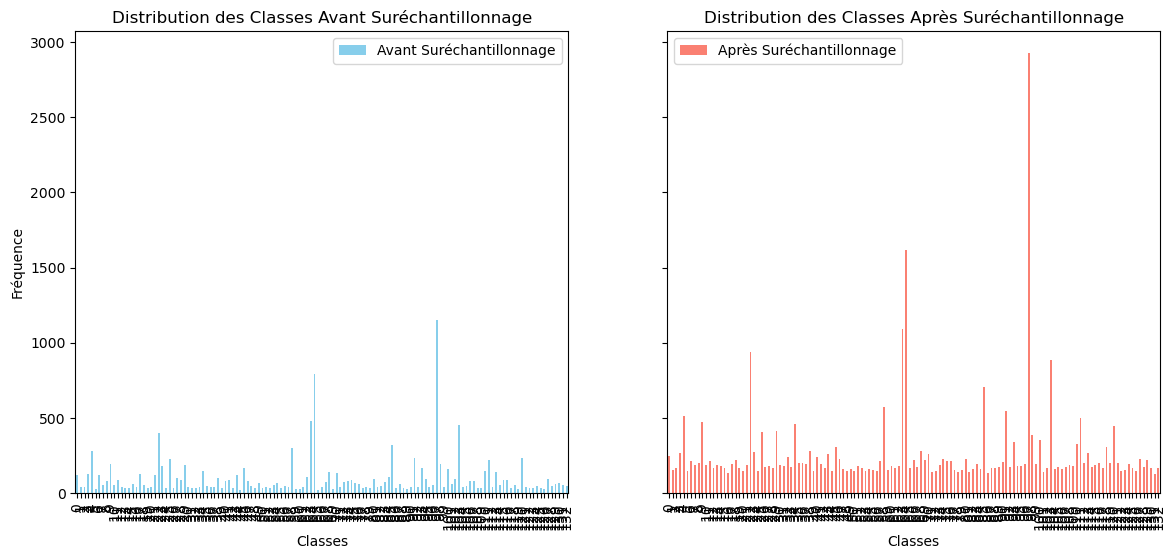

SGDClassifier (OneVsRest)_CountVectorizer__temporal_split_2 Classification Report:
{
    "micro avg": {
        "precision": 0.133503935106948,
        "recall": 0.6460280373831776,
        "f1-score": 0.22127966067784402,
        "support": 4280.0
    },
    "macro avg": {
        "precision": 0.12469827463836664,
        "recall": 0.556094280846387,
        "f1-score": 0.19262296529802286,
        "support": 4280.0
    },
    "weighted avg": {
        "precision": 0.2109627347871377,
        "recall": 0.6460280373831776,
        "f1-score": 0.30138827122370904,
        "support": 4280.0
    },
    "samples avg": {
        "precision": 0.19073971997524075,
        "recall": 0.5992833333333333,
        "f1-score": 0.2561178055030197,
        "support": 4280.0
    }
}
Jaccard Score: 0.17
Word Coverage: 0.23


C:\Users\MAUD\anaconda3\Lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
C:\Users\MAUD\anaconda3\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
Registered model 'SGDClassifier (OneVsRest)_CountVectorizer' already exists. Creating a new version of this model...
2024/11/08 21:17:41 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: SGDClassifier (OneVsRest)_CountVectorizer, version 3
Created version '

Le modèle 'SGDClassifier (OneVsRest)_CountVectorizer__temporal_split_2' a été enregistré dans le Model Registry avec le nom 'SGDClassifier (OneVsRest)_CountVectorizer'.


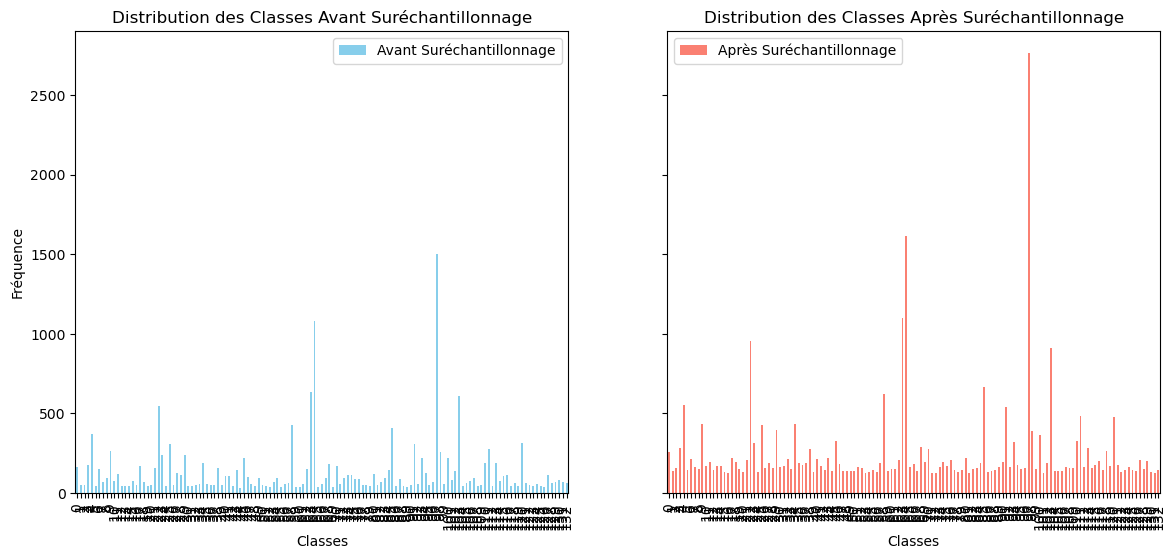

SGDClassifier (OneVsRest)_CountVectorizer__temporal_split_3 Classification Report:
{
    "micro avg": {
        "precision": 0.11274158911954188,
        "recall": 0.6673728813559322,
        "f1-score": 0.192896509491733,
        "support": 4248.0
    },
    "macro avg": {
        "precision": 0.108692820934659,
        "recall": 0.5999555020015196,
        "f1-score": 0.17296147679632187,
        "support": 4248.0
    },
    "weighted avg": {
        "precision": 0.19273394640598365,
        "recall": 0.6673728813559322,
        "f1-score": 0.277846390207906,
        "support": 4248.0
    },
    "samples avg": {
        "precision": 0.15568290777151778,
        "recall": 0.6164166666666667,
        "f1-score": 0.22367894163584295,
        "support": 4248.0
    }
}
Jaccard Score: 0.14
Word Coverage: 0.20


C:\Users\MAUD\anaconda3\Lib\site-packages\_distutils_hack\__init__.py:18: UserWarning: Distutils was imported before Setuptools, but importing Setuptools also replaces the `distutils` module in `sys.modules`. This may lead to undesirable behaviors or errors. To avoid these issues, avoid using distutils directly, ensure that setuptools is installed in the traditional way (e.g. not an editable install), and/or make sure that setuptools is always imported before distutils.
  warnings.warn(
C:\Users\MAUD\anaconda3\Lib\site-packages\_distutils_hack\__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
Registered model 'SGDClassifier (OneVsRest)_CountVectorizer' already exists. Creating a new version of this model...
2024/11/08 21:18:42 INFO mlflow.store.model_registry.abstract_store: Waiting up to 300 seconds for model version to finish creation. Model name: SGDClassifier (OneVsRest)_CountVectorizer, version 4


Le modèle 'SGDClassifier (OneVsRest)_CountVectorizer__temporal_split_3' a été enregistré dans le Model Registry avec le nom 'SGDClassifier (OneVsRest)_CountVectorizer'.


Created version '4' of model 'SGDClassifier (OneVsRest)_CountVectorizer'.


[]

In [22]:
# Exécuter l'évaluation temporelle avec suréchantillonnage
temporal_evaluation(df_reduit, df_tags_reduit, tfidf_vectorizer, logistic_regression_model, params_tfidf_lr, n_splits=5)
temporal_evaluation(df_reduit, df_tags_reduit, count_vectorizer, logistic_regression_model, params_count_lr, n_splits=5)

temporal_evaluation(df_reduit, df_tags_reduit, tfidf_vectorizer, sgd_classifier_model, params_tfidf_sgd, n_splits=5)
temporal_evaluation(df_reduit, df_tags_reduit, count_vectorizer, sgd_classifier_model, params_count_sgd, n_splits=5)

In [53]:
def load_model_and_vectorizer(model_path, vectorizer_path):
    """
    Charge le modèle et le vectoriseur sauvegardés avec joblib.
    
    Parameters:
        model_path (str): Chemin du fichier du modèle.
        vectorizer_path (str): Chemin du fichier du vectoriseur.
    
    Returns:
        model, vectorizer: Le modèle et le vectoriseur chargés.
    """
    model = joblib.load(model_path)
    vectorizer = joblib.load(vectorizer_path)
    return model, vectorizer

In [55]:
def predict_tags_for_question(question, model, vectorizer, pca, mlb, threshold=0.5):
    # Vectoriser la question
    question_vect = vectorizer.transform([question])
    
    # Appliquer la réduction de dimension avec PCA
    question_vect = pca.transform(question_vect.toarray())
    
    # Prédire les probabilités pour chaque classe (tag)
    y_pred_proba = model.predict_proba(question_vect)[0]
    
    # Appliquer le seuil pour sélectionner les tags
    predicted_indices = np.where(y_pred_proba >= threshold)[0]
    
    # Si aucun tag ne dépasse le seuil, on choisit les 5 meilleures probabilités
    if len(predicted_indices) == 0:
        predicted_indices = np.argsort(y_pred_proba)[-5:]
    
    # Récupérer les noms des tags prédits
    tags = mlb.classes_[predicted_indices]
    return tags

In [57]:
# Charger le modèle, le vectoriseur et le binariseur
model_path = "logistic-regression-onevsrest-tfidfvectorizer-temporal-split-0_model.pkl"  # Remplacez par le chemin de votre modèle
vectorizer_path = "logistic-regression-onevsrest-tfidfvectorizer-temporal-split-0_vectorizer.pkl"  # Remplacez par le chemin de votre vectoriseur
pca_path = "logistic-regression-onevsrest-countvectorizer__temporal_split_0_pca.pkl"
mlb_path = "logistic-regression-onevsrest-tfidfvectorizer-temporal-split-0_mlb.pkl"  # Remplacez par le chemin du MultiLabelBinarizer

model, vectorizer = load_model_and_vectorizer(model_path, vectorizer_path)
pca = joblib.load(pca_path)
mlb = joblib.load(mlb_path)

In [59]:
# Utiliser une question en dur
question = "How to integrate my css file into my project ?"
predicted_tags = predict_tags_for_question(question, model, vectorizer, pca, mlb)

In [61]:
# Afficher les tags prédits
print("Tags prédits pour la question :", predicted_tags)

Tags prédits pour la question : ['.net' '.net-core' 'algorithm' 'amazon-web-services' 'android'
 'android-studio' 'api' 'asp.net' 'asp.net-core' 'asynchronous'
 'aws-lambda' 'azure' 'bash' 'blazor' 'c' 'c#' 'c++' 'class' 'csv' 'dart'
 'dataframe' 'date' 'datetime' 'dictionary' 'docker' 'docker-compose'
 'excel' 'filter' 'firebase' 'flutter' 'for-loop' 'frontend' 'function'
 'ggplot2' 'git' 'github' 'google-cloud-platform' 'gradle' 'group-by'
 'if-statement' 'image' 'ios' 'java' 'json' 'kotlin' 'kubernetes' 'linux'
 'list' 'loops' 'machine-learning' 'macos' 'matplotlib' 'maven'
 'multithreading' 'next.js' 'npm' 'numpy' 'office-addins' 'outlook'
 'pandas' 'performance' 'postgresql' 'powershell' 'pyspark' 'python'
 'python-3.x' 'pytorch' 'r' 'react-hooks' 'react-native' 'regex' 'rest'
 'selenium' 'selenium-webdriver' 'shell' 'sorting' 'sql-server' 'string'
 'swift' 'tensorflow' 'unit-testing' 'unity-game-engine' 'vba'
 'visual-studio-code' 'vue.js' 'windows' 'wordpress' 'xml']
